In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
import os
import segmentation_models_pytorch as smp


In [ ]:
# u-net with resnet34
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=4,                  # R + G + B + NIR ( don't know if it's working?)
    classes=1,                      # Binary segmentation
    activation='sigmoid'
)

#loss & optimizer
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #optimizer


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [7]:
#choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

cuda


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
class AmazonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)

            # min-max normalization
            # don't know if it's doing a good job lmao
            for b in range(image.shape[0]):
                image[b] = (image[b] - image[b].min()) / (image[b].max() - image[b].min() + 1e-8)

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return image, mask

dataset_dir = '/content/drive/MyDrive/AMAZON/Training'
train_dataset = AmazonDataset(image_dir=dataset_dir+'/image', mask_dir=dataset_dir+'/label')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        #forward
        outputs = model(images)

        #backward
        loss = criterion(outputs, masks)
        loss.backward()

        #weight optmimization
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), 'amazon_unet_resnet34.pth')
print("Entrenamiento completado y modelo guardado.")

Epoch [1/25], Loss: 0.3995
Epoch [2/25], Loss: 0.3739
Epoch [3/25], Loss: 0.3661
Epoch [4/25], Loss: 0.3591
Epoch [5/25], Loss: 0.3551
Epoch [6/25], Loss: 0.3512
Epoch [7/25], Loss: 0.3497
Epoch [8/25], Loss: 0.3514
Epoch [9/25], Loss: 0.3473
Epoch [10/25], Loss: 0.3455
Epoch [11/25], Loss: 0.3480
Epoch [12/25], Loss: 0.3467
Epoch [13/25], Loss: 0.3431
Epoch [14/25], Loss: 0.3434
Epoch [15/25], Loss: 0.3416
Epoch [16/25], Loss: 0.3458
Epoch [17/25], Loss: 0.3451
Epoch [18/25], Loss: 0.3430
Epoch [19/25], Loss: 0.3427
Epoch [20/25], Loss: 0.3407
Epoch [21/25], Loss: 0.3384
Epoch [22/25], Loss: 0.3452
Epoch [23/25], Loss: 0.3411
Epoch [24/25], Loss: 0.3434
Epoch [25/25], Loss: 0.3393
Entrenamiento completado y modelo guardado.


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


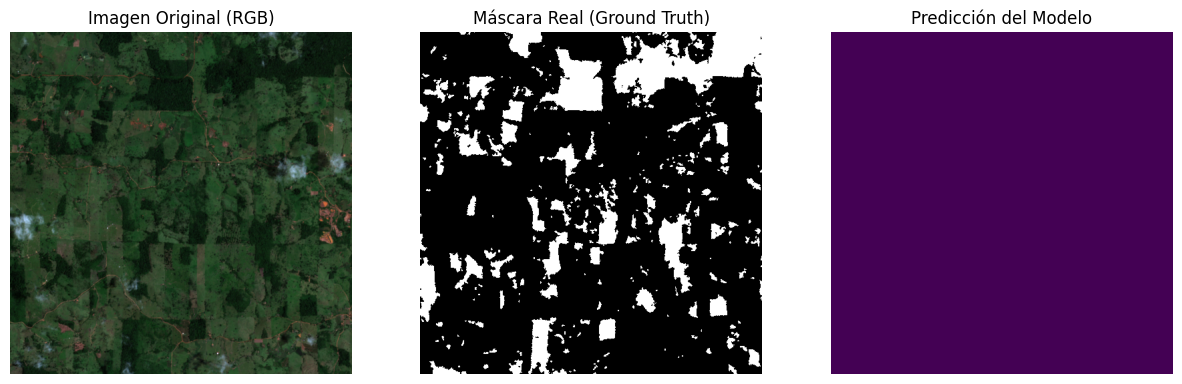

In [ ]:
def visualize_prediction(model, dataloader, device):
    model.eval()

    images, masks = next(iter(dataloader))

    images = images.to(device)
    with torch.no_grad():
        output = model(images)
        prediction = (torch.sigmoid(output) > 0.5).float()

    img = images[0][:3].cpu().permute(1, 2, 0).numpy() # Solo RGB
    true_mask = masks[0].cpu().squeeze().numpy()
    pred_mask = prediction[0].cpu().squeeze().numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original (RGB)")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("(Ground Truth)")
    plt.imshow(true_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred_mask, cmap='viridis') 
    plt.axis('off')

    plt.show()

visualize_prediction(model, train_loader, device)